# Initial Setup

In [2]:
import numpy as np
import matplotlib.pyplot as plt
from collections import defaultdict

import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F

from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report

import seaborn as sns
from tqdm import tqdm
import warnings

warnings.filterwarnings('ignore')

np.random.seed(42)
torch.manual_seed(42)


## Activation Functions


In [3]:
def sigmoid(z):
  """
  Sigmoid activation function: σ(z) = 1 / (1 + e^(-z))
  Maps any real value to the range (0,1)
  """

  return 1/(1+np.exp(-z))

def relu(z):
  """
  Rectified Linear Unit: ReLU(z) = max(0, z)
  Returns z if positive, 0 otherwise
  """
  return(np.maximum(z,0))


def tanh(z):
  """
  Hyperbolic tangent activation: tanh(z) = (e^z - e^(-z)) / (e^z + e^(-z))
  Maps any real value to the range (-1,1)
  """

  return ((np.exp(z) - np.exp(-z))/(np.exp(z)+np.exp(-z)))



print(round(tanh(5),15) == round(np.tanh(5),15))
print(round(tanh(5),16) == round(np.tanh(5),16)) ## np.tanh has more floating points


True
False


### Visualization

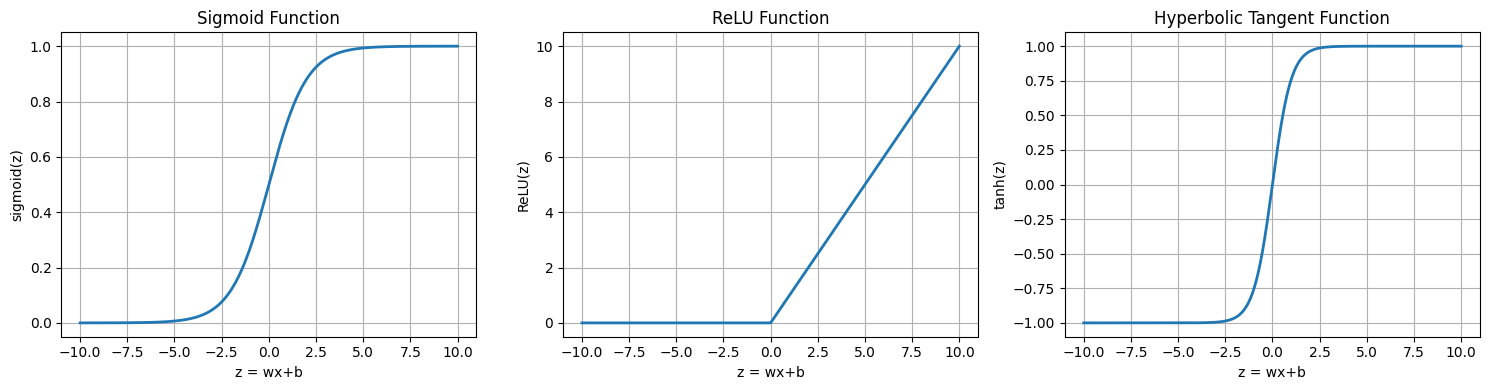

In [4]:
z = np.linspace(-10, 10, 1000)

plt.figure(figsize=(15,4))

# Sigmoid
plt.subplot(1,3,1) # *nrows*, *ncols*, *index: 1 row, 3 cols, position 1
plt.plot(z,sigmoid(z),linewidth=2)
plt.grid(True)
plt.xlabel("z = wx+b")
plt.ylabel("sigmoid(z)")
plt.title("Sigmoid Function")

# ReLU
plt.subplot(1,3,2)
plt.plot(z, relu(z), linewidth=2)
plt.grid(True)
plt.xlabel("z = wx+b")
plt.ylabel("ReLU(z)")
plt.title("ReLU Function")

# Hypebolic Tangent
plt.subplot(1,3,3)
plt.plot(z, tanh(z), linewidth=2)
plt.grid(True)
plt.xlabel("z = wx+b")
plt.ylabel("tanh(z)")
plt.title("Hyperbolic Tangent Function")

plt.tight_layout() # Adjust the padding between and around subplots


plt.show()

## Derivatives of Activation Functions

In [5]:
def sigmoid_derivative(z):
  """Derivative of sigmoid: σ'(z) = σ(z)(1-σ(z))"""
  s = sigmoid(z)

  return(s * (1-s))

def tanh_derivative(z):
  """Derivative of tanh: tanh'(z) = 1 - tanh²(z)"""

  return(1 - np.tanh(z)**2)

def relu_derivative(z):
  """Derivative of ReLU: 1 if z > 0, 0 otherwise"""

  return(z > 0).astype(float)


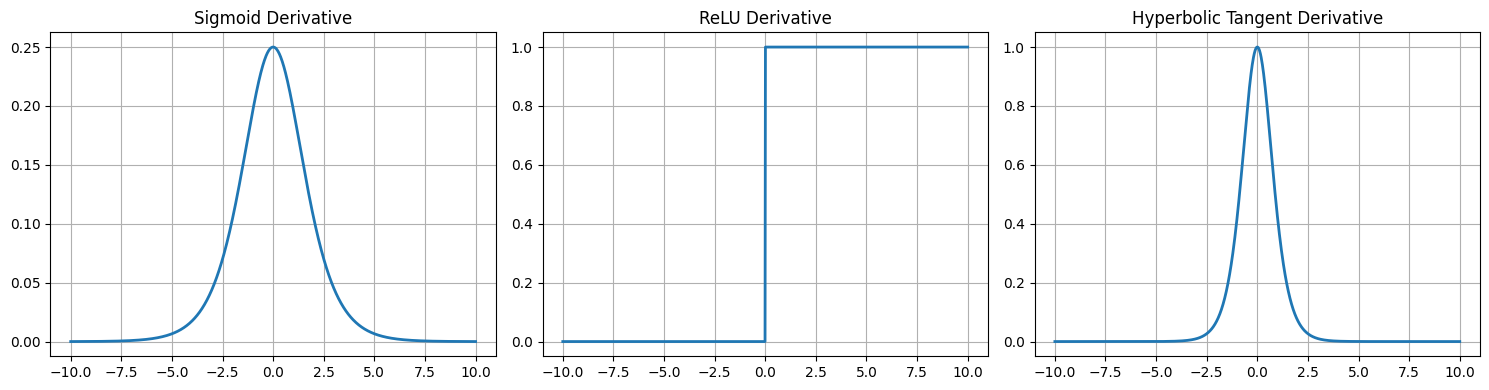

In [6]:
plt.figure(figsize=(15,4)) # 5 each graph

# Sigmoid derivative
plt.subplot(1,3,1) # *nrows*, *ncols*, *index: 1 row, 3 cols, position 1
plt.plot(z, sigmoid_derivative(z), linewidth=2)
plt.title("Sigmoid Derivative")
plt.grid(True)


# ReLU derivative
plt.subplot(1,3,2)
plt.plot(z, relu_derivative(z), linewidth=2)
plt.title("ReLU Derivative")
plt.grid(True)


# tanh derivative
plt.subplot(1,3,3)
plt.plot(z, tanh_derivative(z), linewidth=2)
plt.title("Hyperbolic Tangent Derivative")
plt.grid(True)

plt.tight_layout()
plt.show()


#Neural Unit

In [7]:
class NeuralUnit:
  """
  Single Neural Unit that computes: y = activation(w.x + b)
  """

  def __init__(self, n_inputs, activation='sigmoid'):
    self.weights = np.random.randn(n_inputs) * 0.1 # Must not be zero, if not weights learn nothing. Diff from LogReg
    self.bias = 0.0

    # set activation function
    self.activation_name = activation

    if activation == 'sigmoid':
      self.activation = sigmoid
      self.activation_derivative = sigmoid_derivative

    elif activation == 'tanh':
      self.activation = tanh
      self.activation_derivative = tanh_derivative

    elif activation == 'relu':
      self.activation = relu
      self.activation_derivative = relu_derivative


  def forward(self, x):
    """Forward pass: compute output given input x"""

    # Linear combination: z = w·x + b
    self.z = np.dot(x, self.weights) + self.bias

    # Activation function
    self.output = self.activation(self.z)

    return(self.output)


  def __repr__(self):
    return f"NeuralUnit(weights={self.weights}, bias={self.bias:.3f}, activation={self.activation_name})"


In [8]:
neural_unit = NeuralUnit(n_inputs=10, activation = 'sigmoid')

x = np.random.randn(10)

z = neural_unit.forward(x)

print(f"Input: {x}")
print(f"Weights: {neural_unit.weights}")
print(f"Bias: {neural_unit.bias}")
print(f"z = w·x + b = {neural_unit.z:.3f}")
print(f"Input shape: {x.shape}")
print(f"Output: {z}")


Input: [-0.46341769 -0.46572975  0.24196227 -1.91328024 -1.72491783 -0.56228753
 -1.01283112  0.31424733 -0.90802408 -1.4123037 ]
Weights: [ 0.04967142 -0.01382643  0.06476885  0.15230299 -0.02341534 -0.0234137
  0.15792128  0.07674347 -0.04694744  0.054256  ]
Bias: 0.0
z = w·x + b = -0.409
Input shape: (10,)
Output: 0.3992529343829082


# The XOR Problem

## Perceptron
### Demonstrating that a single perceptron cannot solve XOR

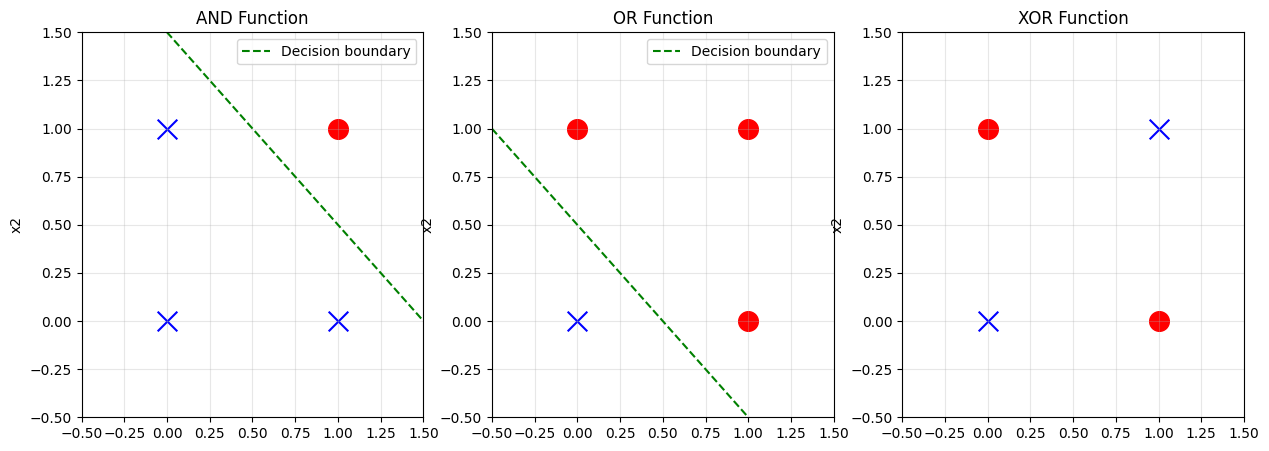

In [10]:
def perceptron(x, w, b):
  """Simple perceptron with step activation"""
  z = np.dot(x,w) + b

  return(1 if z > 0 else 0 )


# XOR Truth Table
X_xor = np.array([[0,0], [0,1], [1,0], [1,1]]) # the 4 possible combinations

y_xor = np.array([0,1,1,0]) # XOR outputs

# AND Truth Table
y_and = np.array([0,0,0,1]) # AND outputs

# OR Truth Table
y_or = np.array([0,1,1,1]) # OR outputs


# Visualize problem
fig, axes = plt.subplots(1,3, figsize=(15,5) ) # 1 row, 3 cols

for ax, y, title in zip(axes, [y_and, y_or, y_xor], ['AND', 'OR', 'XOR']):
  # Plot points
  for i in range(4):
    color = 'red' if y[i] == 1 else 'blue'
    marker = 'o' if y[i] == 1 else 'x'
    ax.scatter(X_xor[i, 0], X_xor[i, 1], c=color, s=200, marker=marker)

  ax.set_xlim(-.5,1.5)
  ax.set_ylim(-.5,1.5)
  ax.set_ylabel('x2')
  ax.set_title(f'{title} Function')
  ax.grid(True, alpha=0.3)

  # Adding Decision Boundaries
  if title=='AND':
    # Decision boundary: x1 + x2 - 1.5 = 0
    x_line = np.linspace(-0.5, 1.5, 100)
    y_line = 1.5 - x_line
    ax.plot(x_line, y_line, 'g--', label='Decision boundary')
  elif title == 'OR':
    # Decision boundary: x1 + x2 - 0.5 = 0
    x_line = np.linspace(-0.5, 1.5, 100)
    y_line = 0.5 - x_line
    ax.plot(x_line, y_line, 'g--', label='Decision boundary')

  if title != 'XOR':
    ax.legend()

plt.show()


## Notes about `@` vs `np.dot()` vs `*`

The `@` operator in Python/NumPy is the **matrix multiplication operator**:


```python
import numpy as np

A = np.array([[1, 2], [3, 4]])
B = np.array([[5, 6], [7, 8]])
v = np.array([1, 2])

# Matrix multiplication
A @ B       # Same as np.matmul(A, B)
np.dot(A, B)  # Also matrix multiplication for 2D arrays

# Element-wise multiplication  
A * B       # Different! Multiplies corresponding elements
```

## How `@` Behaves with Different Dimensions

### 1. **Matrix × Matrix** → Matrix multiplication (Row × Column)
```python
[[1, 2]    [[5, 6]     [[19, 22]
 [3, 4]] @  [7, 8]]  =  [43, 50]]
```

### 2. **Matrix × Vector** → Matrix-vector multiplication
```python
[[1, 2]    [5]     [1×5 + 2×6]     [17]
 [3, 4]] @ [6]  =  [3×5 + 4×6]  =  [39]
```

### 3. **Vector × Vector** → Dot product (scalar)
```python
[1, 2] @ [3, 4] = 1×3 + 2×4 = 11  # Returns scalar!
```


## Solving XOR with Neural Network

In [50]:
class XORNetwork:
  """
  2-layer network to solve the XOR Problem
  2 inputs -> 2 hidden units -> 1 output
  """

  def __init__(self):
    # Hidden layer weights (example from the book originally from Bengio)

    """
    NumPy's @ operator (or np.dot) automatically treats the 1D array x as a column vector:
    [[1, 1]    [[0]     [[1×0 + 1×0]     [[0]
    [1, 1]] @  [0]]  =  [1×0 + 1×0]]  =  [0]]

    For input [0, 0]:
    Row 1: 1×0 + 1×0 = 0
    Row 2: 1×0 + 1×0 = 0
    Result: [0, 0]

    For input [1, 1]:
    Row 1: 1×1 + 1×1 = 2
    Row 2: 1×1 + 1×1 = 2
    Result: [2, 2]
    """

    self.W1 = np.array([[1,1],   # weights for h1
                        [1,1]])  # weights for h2

    self.b1 = np.array([0,-1])

    self.W2 = np.array([[1,-2]])
    self.b2 = np.array([0])

  def forward(self,x):
    # Hidden layer with ReLU

    self.z1 = np.dot(self.W1,x) + self.b1  # NumPy's @ operator (or np.dot) automatically treats the 1D array x as a column vector
    print(f"z1 = {self.W1}@{x} + {self.b1}")

    # W1 @ x: (2,2) @ (2,) → (2,) - returns a 1D array
    # Example: [[1,1],[1,1]] @ [1,1] → [2, 2] (vector)


    self.h = relu(self.z1)
    print(f"h = {self.h}")

    # Output layer (linear)
    self.z2 = np.dot(self.W2, self.h) + self.b2
    print(f"z2 = {self.W2}@{self.h} + {self.b2}")

    # W2 @ h: (1,2) @ (2,) → (1,) - returns a 1D array with one element
    # Example: [[1,-2]] @ [2,1] → [0] (


    print(f"z2 = {self.z2}")
    self.y = self.z2[0]   #  We use the [0] to extract the scalar from the array
    print("\n\n")
    return(self.y)

  def predict(self,x):
    """Binary prediction with threshold at 0"""

    return (self.forward(x) > 0).astype(int)


### Test XOR network


XOR Network Predictions:
------------------------------
z1 = [[1 1]
 [1 1]]@[0 0] + [ 0 -1]
h = [0 0]
z2 = [[ 1 -2]]@[0 0] + [0]
z2 = [0]



Input: [0 0] -> Predicted: 0, True: 0
z1 = [[1 1]
 [1 1]]@[0 1] + [ 0 -1]
h = [1 0]
z2 = [[ 1 -2]]@[1 0] + [0]
z2 = [1]



Input: [0 1] -> Predicted: 1, True: 1
z1 = [[1 1]
 [1 1]]@[1 0] + [ 0 -1]
h = [1 0]
z2 = [[ 1 -2]]@[1 0] + [0]
z2 = [1]



Input: [1 0] -> Predicted: 1, True: 1
z1 = [[1 1]
 [1 1]]@[1 1] + [ 0 -1]
h = [2 1]
z2 = [[ 1 -2]]@[2 1] + [0]
z2 = [0]



Input: [1 1] -> Predicted: 0, True: 0
z1 = [[1 1]
 [1 1]]@[0 0] + [ 0 -1]
h = [0 0]
z2 = [[ 1 -2]]@[0 0] + [0]
z2 = [0]



z1 = [[1 1]
 [1 1]]@[0 1] + [ 0 -1]
h = [1 0]
z2 = [[ 1 -2]]@[1 0] + [0]
z2 = [1]



z1 = [[1 1]
 [1 1]]@[1 0] + [ 0 -1]
h = [1 0]
z2 = [[ 1 -2]]@[1 0] + [0]
z2 = [1]



z1 = [[1 1]
 [1 1]]@[1 1] + [ 0 -1]
h = [2 1]
z2 = [[ 1 -2]]@[2 1] + [0]
z2 = [0]





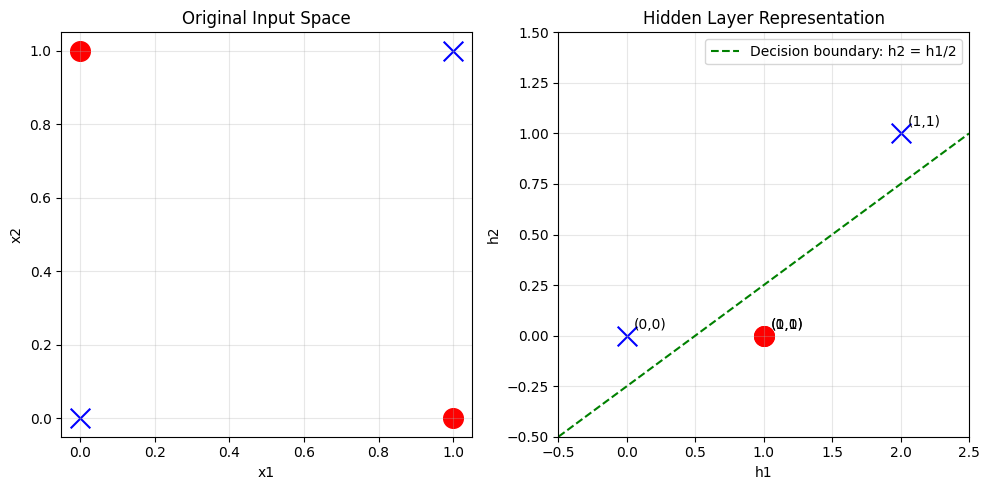

In [51]:
xor_net = XORNetwork()

print("XOR Network Predictions:")
print("-" * 30)
for i, x in enumerate(X_xor):
  prediction = xor_net.predict(x)
  print(f"Input: {x} -> Predicted: {prediction}, True: {y_xor[i]}")

# Visualize hidden layer representations
hidden_representations = []
for x in X_xor:
  xor_net.forward(x)
  hidden_representations.append(xor_net.h)

hidden_representations = np.array(hidden_representations)

plt.figure(figsize=(10, 5))

# Original space
plt.subplot(1, 2, 1)
for i in range(4):
  color = 'red' if y_xor[i] == 1 else 'blue'
  marker = 'o' if y_xor[i] == 1 else 'x'
  plt.scatter(X_xor[i, 0], X_xor[i, 1], c=color, s=200, marker=marker)
plt.xlabel('x1')
plt.ylabel('x2')
plt.title('Original Input Space')
plt.grid(True, alpha=0.3)

# Hidden layer space
plt.subplot(1, 2, 2)
for i in range(4):
  color = 'red' if y_xor[i] == 1 else 'blue'
  marker = 'o' if y_xor[i] == 1 else 'x'
  plt.scatter(hidden_representations[i, 0], hidden_representations[i, 1],c=color, s=200, marker=marker)
  plt.annotate(f'({X_xor[i,0]},{X_xor[i,1]})', (hidden_representations[i, 0], hidden_representations[i, 1]), xytext=(5, 5), textcoords='offset points')

h1_range = np.linspace(-0.5, 2.5, 100)
h2_boundary = h1_range / 2 -.25 # Shifted -0.25 boundary for clearer visualization

plt.plot(h1_range, h2_boundary, 'g--', label='Decision boundary: h2 = h1/2')

plt.xlabel('h1')
plt.ylabel('h2')
plt.title('Hidden Layer Representation')
plt.grid(True, alpha=0.3)
plt.xlim(-0.5, 2.5)
plt.ylim(-0.5, 1.5)
plt.legend()

plt.tight_layout()
plt.show()